In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
# Examining the dataset
print(f"""{words[:10]}\n
 min word length: {min(len(w) for w in words)}\n
  max word length: {max(len(w) for w in words)}""")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

 min word length: 2

  max word length: 15


### First, we build a Bigram,

which unlike transformers, ..., only looks at the immediately preceeding character (like for isabella, 'a' before 'b'). In modern times we use all the information at our disposal, 'i' -> 's', 'is' -> 'a', 'isa' -> b, ...

In [5]:
for w in words[:1]:
    # for char in range(1, len(w)):
    #     print(w[char-1], w[char])
    # # Psycho karpathy does this
    # We also have info on special start and special end positions, so let's add/hallucinate that in
    chs =  ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


In [6]:
# That zip stuff works because,
print(w, w[1:]) # And then zipping it iterates them, groups them together em, mm, ma and stops when one can't iterata anymore
print(list(zip(w, w[1:])))

emma mma
[('e', 'm'), ('m', 'm'), ('m', 'a')]


In [7]:
### Anyways, he changed all the codeblocks above but we're learning so I'll keep them :P. 
# We add a dictionary to see how many times each sequence has occured,
b = {}
for w in words:
    chs =  ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2) # key
        b[bigram] = b.get(bigram, 0) + 1 # just adds one every time we see bigram, and initiates if never seen before
        # print(ch1, ch2)

In [8]:
sorted(b.items(), key = lambda keyval: -keyval[1]) 
# Custom key -- sort by 2nd object (our actual counts and not keys so [1]), by reverse order (-ve)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

 # Cool!
 Seems like an ending always follows 'n', and 'a' -> 'n' very often. Anti :flushed:
 It'll be way more efficient if we actually stored this info in a 2D array.
 We'll have our rows as first letters, columns as second letter, 
 and its index (element) is the # of times this (second letter following the first) occurs!

my prediction: so it should be a 28x28 array right? (including the special start/end chars) || It was :P heeheh


In [9]:
import torch

In [10]:
N = torch.zeros((28, 28), dtype=torch.int32)

In [18]:
# Um karpathy...?? To get a char lookup table, he joins the entire set together, sets it to remove dupes, sorts and converts to list
# Although, it makes sense in general context
chars = list(sorted((set(''.join(words))))) # list a-z
string_to_int =  {s:i for i,s in enumerate(chars)}
string_to_int['<S>'] = 26 # add our special tokens
string_to_int['<E>'] = 27 

In [12]:
for w in words:
    chs =  ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        N[ix1, ix2] += 1   # Btw, this is one way to index arrays.
        # Like for random 2D tensor a, you could go a[2,4] or a[2][4] to get that element. [2,4] is [row, col] (from 0 index ofc) 

Okay, cool! We now have a bigram. Here, it's a 2D array containing the number of times a letter (from col) follows a letter (from row). E.g row 0, col 1 would be 'ab' -- how many times did b follow an a?
Let's try to visualise it in a pretty way now.

(-0.5, 27.5, 27.5, -0.5)

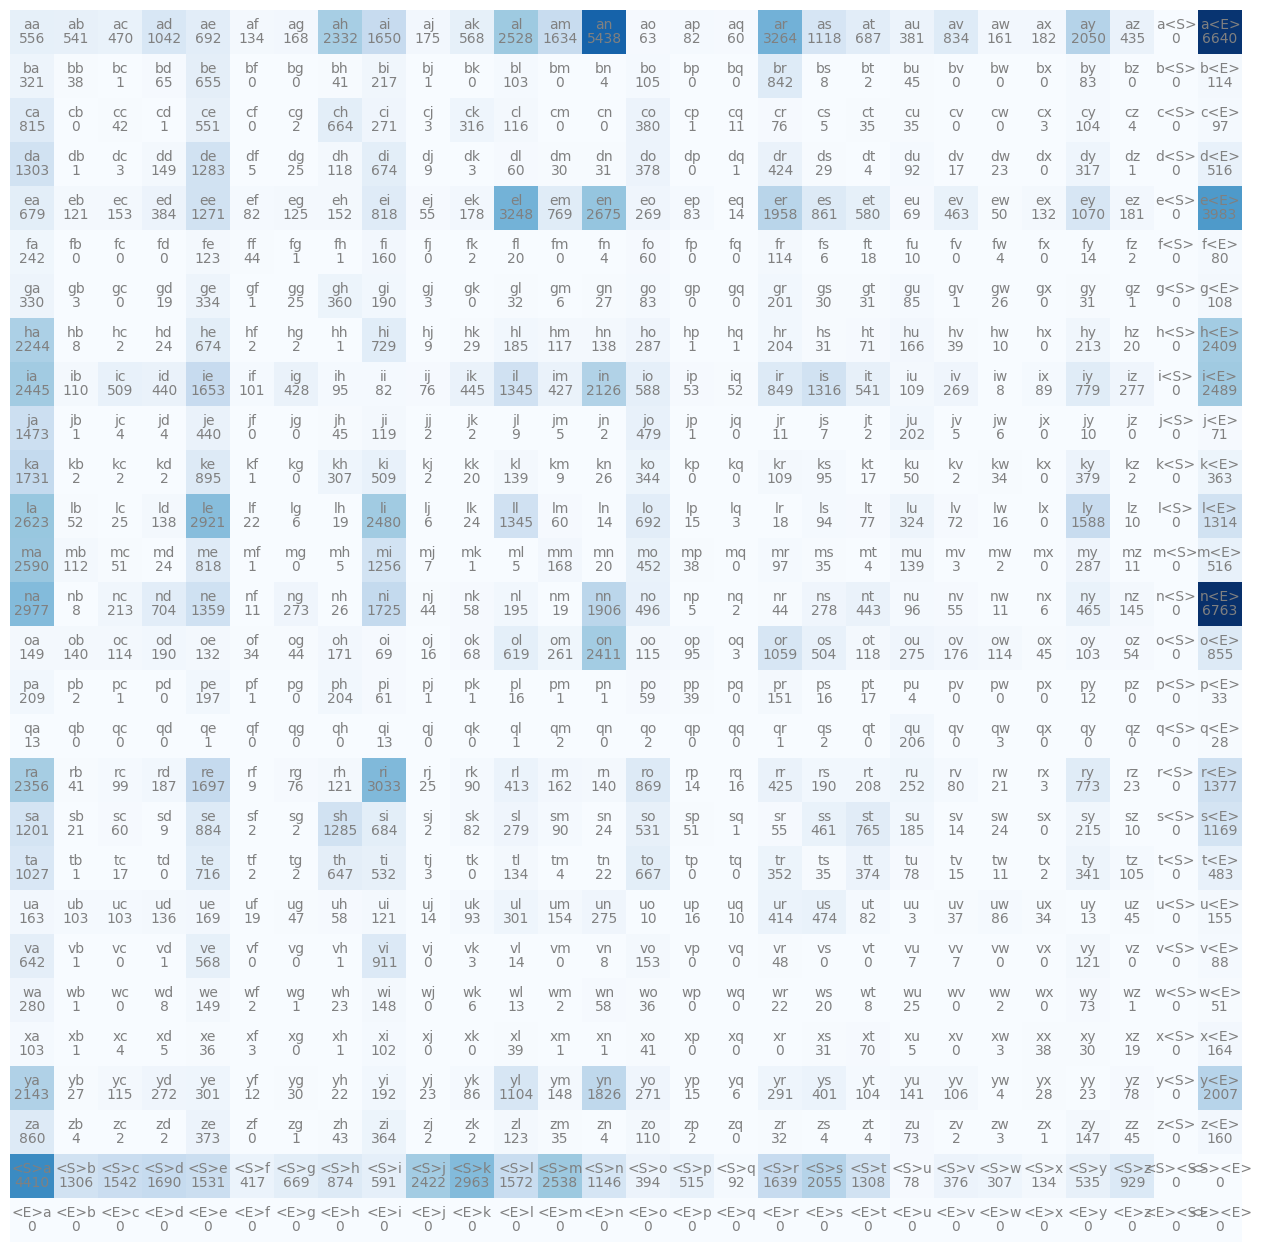

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
# N  # just a sussy matrix with numbers boooooooo
# plt.imshow(N) # getting there, still a bit ugly
int_to_string =  {i:s for s, i in string_to_int.items()}

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(28):
    for j in range(28):
        chrstr = int_to_string[i] + int_to_string[j] # ab, aj, cl, ...
        plt.text(j, i, chrstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray") # .item() to get the int in the tensor element
plt.axis('off')